In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Colab_Notebooks/cs7643-project/inversecooking-master/src


/content/drive/MyDrive/Colab_Notebooks/cs7643-project/inversecooking-master/src


In [4]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time

In [5]:
data_dir = '../data'

In [6]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
print(torch.cuda.is_available())
print('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'
print(map_loc)

False
cpu
cpu


In [7]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [8]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [9]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.fo

loaded model
Elapsed time: 11.49074649810791


In [10]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [11]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

In [12]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid

# image_folder = os.path.join(data_dir, 'demo_imgs')

image_folder=os.path.join(data_dir,'my_food')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

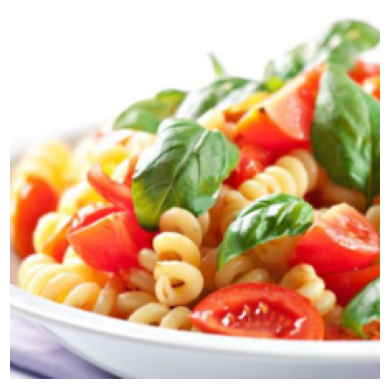

/content/drive/MyDrive/Colab_Notebooks/cs7643-project/inversecooking-master/src/modules/multihead_attention.py:126: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:1772.)
  attn_weights = attn_weights.float().masked_fill(


RECIPE 1
Title: Caprese pasta

Instructions: 
-Cook pasta according to package directions.
-Drain and set aside.
-In a large bowl, combine tomatoes, basil, olive oil, salt and pepper.
-Add pasta and toss to coat.
-Top with parmesan cheese.
----------
RECIPE 2
Title: Caprese pasta

Instructions: 
-Bring a large pot of lightly salted water to a boil.
-Cook pasta in the boiling water, stirring occasionally, until cooked through but firm to the bite, about 11 minutes.
-Drain well in a colander set in the sink.
-Heat olive oil in a large skillet over medium-high heat.
-Saute roma tomatoes in hot oil until tender, about 5 minutes; transfer to a serving bowl and stir in feta cheese and mozzarella cheese.
-Toss cooked and cooled pasta with tomato mixture and basil in a large bowl.
-Season with salt and black pepper.
----------
RECIPE 3
Title: Basil & roasted red pepper bow ties with goat cheese

Instructions: 
-Combine first 4 ingredients in large bowl; toss to coat.
-Sprinkle with salt and pe

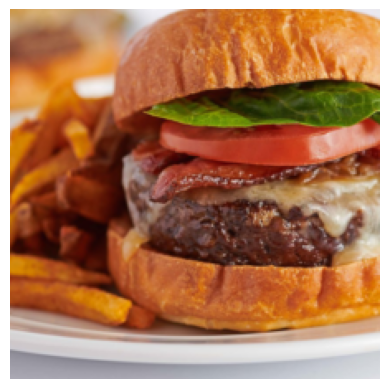

RECIPE 1
Title: Blue cheese burgers

Instructions: 
-In a large bowl, combine the ground beef, blue cheese, worcestershire sauce, salt and pepper.
-Form into 4 patties.
-Grill over medium heat for 5 minutes per side, or until desired doneness.
-Top each burger with a slice of tomato and a slice of onion.
----------
RECIPE 2
Title: Beef burger with onion and tomato

Instructions: 
-Heat gas grill on medium or charcoal grill until coals are ash white.
-Mix ground beef, worcestershire sauce and garlic salt in bowl.
-Shape beef mixture into 4 patties.
-Place patties onto grill.
-Grill, turning once, 10-12 minutes or until internal temperature reaches at least 160f, brushing occasionally with worcestershire sauce.
-Place burgers onto bottom halves of buns; top each with 1/4 of cheese slices and tomatoes.
-Cover; let stand 5 minutes before serving.
----------
RECIPE 3
Title: Cheeseburger joes

Instructions: 
-Heat a large skillet over medium-high heat.
-Add beef; cook 4 minutes or until brow

In [15]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        if valid['is_valid'] or show_anyways:
            
            print ('RECIPE', num_valid)
            num_valid+=1
            #print ("greedy:", greedy[i], "beam:", beam[i])
    
            # BOLD = '\033[1m'
            # END = '\033[0m'
            print('Title: '+ outs['title'])

            print('\nInstructions: ')
            print('-'+'\n-'.join(outs['recipe']))
            print('--'*5)
            # print (BOLD + '\nTitle:' + END,outs['title'])

            # # print (BOLD + '\nIngredients:'+ END)
            # # print (', '.join(outs['ingrs']))

            # print (BOLD + '\nInstructions:'+END)
            # print ('-'+'\n-'.join(outs['recipe']))

            # print ('='*20)

        else:
            pass
            print ("Not a valid recipe!")
            print ("Reason: ", valid['reason'])